# Evaluation

**Riaux - Adrien**

## Problématique 

Prédire la classe d'une voiture sachant que : 
- Classe 1 : MPG < 18
- Classe 2 : 18 <= MPG < 24
- Classe 3 : 24 <= MPG < 30
- Classe 4 : MPG >= 30

Nous sommes donc dans un cas de classification. Nous disposons de 4 classes concernant les mpg des voitures de notre dataset, et nous voulons classer des nouvelles voitures dans l'une de ces 4 classes en fonction des autres données à notre disposition. 
Afin d'évaluer notre algorithme nous avons choisis comme metrics l'accuracy. L'accuracy nous donne le pourcentage de voitures correctement classées.

## Etape n°1 - Nettoyage et préparation des données


In [12]:
#Importation des librairies nécessaires pour le projet
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

On met nos données dans un dataframe pour faciliter leurs traitements et leurs analyses.

In [13]:
data = pd.read_csv('car_performance.csv', na_values = ['NA'])
data.head()

,name,origin,year,mpg,cylinders,engine,horsepower,weight,acceleration
0,volvo 245,European,76,20.0,4,130.0,102.0,3150,15.7
1,amc matador,American,76,15.5,8,304.0,120.0,3962,13.9
2,amc hornet sportabout (sw),American,71,18.0,6,258.0,110.0,2962,13.5
3,amc hornet,American,73,18.0,6,232.0,100.0,2945,16.0
4,vw dasher (diesel),European,80,43.4,4,90.0,48.0,2335,23.7


Les données sont dans un format facilement utilisable. On remarque qu'il faudra créer les classes à partir de la colonne mgp.

On regarde maintenant le type de chaque colonne, et si il manque des valeurs dans notre dataframe. 

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          406 non-null    object 
 1   origin        406 non-null    object 
 2   year          406 non-null    int64  
 3   mpg           398 non-null    float64
 4   cylinders     406 non-null    int64  
 5   engine        406 non-null    float64
 6   horsepower    400 non-null    float64
 7   weight        406 non-null    int64  
 8   acceleration  406 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 28.7+ KB


On peut voir qu'il y a des valeurs nulles dans les colonnes mpg et horsepower. Nous allons donc chercher si il est possible de les remplacer. Si cela n'est pas possible, nous supprimerons simplement ces lignes. Cela ne devrait pas détériorer notre modèle puisque qu'elles représentent une quantité minime des individus de notre dataset.

On va maintenant regarder la distribution des données, et plus précisément les outliers de notre dataset.

In [15]:
data.describe()

,year,mpg,cylinders,engine,horsepower,weight,acceleration
count,406.000000,398.000000,406.000000,406.000000,400.000000,406.000000,406.000000
mean,75.921182,23.514573,5.475369,194.779557,105.082500,2979.413793,15.519704
std,3.748737,7.815984,1.712160,104.922458,38.768779,847.004328,2.803359
min,70.000000,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000
25%,73.000000,17.500000,4.000000,105.000000,75.750000,2226.500000,13.700000
50%,76.000000,23.000000,4.000000,151.000000,95.000000,2822.500000,15.500000
75%,79.000000,29.000000,8.000000,302.000000,130.000000,3618.250000,17.175000
max,82.000000,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000


Ce tableau nous donne une bonne idée de la distribution de nos données. Il nous confirme aussi la présence de valeurs nulles. 

De plus nous avons deux varaibles de types object, il serait intéressant de regarder le nombre de valeur unique de valeur qu'elles prennent.

In [16]:
print(f"Nombre de nom --> {data['name'].nunique()} \nNombre d'origin --> {data['origin'].unique()}")

Nombre de nom --> 312 
Nombre d'origin --> ['European' 'American' 'Japanese']


On a donc 3 types d'origines (American, European, Japanese) et 312 noms de voitures différents.

On s'intéresse maintenant à un point crutial dans la préparation des données : les valeurs manquantes. Nous allons donc observer où se cache les valeurs nulles de notre dataset.

In [17]:
#Recherche des valeurs nulles
data.loc[data['mpg'].isnull() |
         data['horsepower'].isnull()]

,name,origin,year,mpg,cylinders,engine,horsepower,weight,acceleration
53,ford torino (sw),American,70,NaN,8,351.0,153.0,4034,11.0
69,ford pinto,American,71,25.0,4,98.0,NaN,2046,19.0
100,chevrolet chevelle concours (sw),American,70,NaN,8,350.0,165.0,4142,11.5
125,amc rebel sst (sw),American,70,NaN,8,360.0,175.0,3850,11.0
142,saab 900s,European,81,NaN,4,121.0,110.0,2800,15.4
163,amc concord dl,American,82,23.0,4,151.0,NaN,3035,20.5
164,plymouth satellite (sw),American,70,NaN,8,383.0,175.0,4166,10.5
255,volkswagen super beetle 117,European,71,NaN,4,97.0,48.0,1978,20.0
272,ford mustang boss 302,American,70,NaN,8,302.0,140.0,3353,8.0
278,ford maverick,American,74,21.0,6,200.0,NaN,2875,17.0


Les voitures pour lesquelles il manque des valeurs de la colonne "mpg" sont soit d'origine américaine soit européenne. On peut donc remplacer les NaN par la moyenne des valeurs des mpg correspondant à l'origine de la voiture.

Les voitures pour lesquelles il manque des valeurs de la colonne "horsepower" sont d'origine américaine (à une exception près). Nous allons donc les remplacer aussi.

Pour cela on définit une fonction afin de rendre le travail plus rapide et plus simple à la lecture.

In [18]:
def null(data, col):
    for i in ["American", "European"] : 
        average_col = data.loc[data['origin'] == i, col].mean()
        data.loc[(data['origin'] == i) & (data[col].isnull()), col] = average_col
    return data

for cols in ['mpg', 'horsepower'] : 
    data = null(data, cols)

#Vérifiaction
data.loc[data['mpg'].isnull() |
         data['horsepower'].isnull()]

,name,origin,year,mpg,cylinders,engine,horsepower,weight,acceleration


Nous avons donc remplacé toutes les valeurs manquantes. Il ne reste plus qu'une seul opération à réaliser avant de passer à l'analyse graphique de nos données.

En effet à l'aide des informations fournies sur le projet, on peut définir une fonction pour créer nos classes et ainsi procéder à des analyses graphiques.

In [19]:
#Definition d'une fonction pour créer les classes
def my_class(mpg):
    if mpg < 18 : 
        return 1
    elif 18 <= mpg < 24 : 
        return 2
    elif 24 <= mpg < 32 : 
        return 3
    else : 
        return 4

data['mpg'] = data['mpg'].map(my_class)

#Vérification 
data.head()

,name,origin,year,mpg,cylinders,engine,horsepower,weight,acceleration
0,volvo 245,European,76,2,4,130.0,102.0,3150,15.7
1,amc matador,American,76,1,8,304.0,120.0,3962,13.9
2,amc hornet sportabout (sw),American,71,2,6,258.0,110.0,2962,13.5
3,amc hornet,American,73,2,6,232.0,100.0,2945,16.0
4,vw dasher (diesel),European,80,4,4,90.0,48.0,2335,23.7


Maintenant nos données sont prêtes à être graphiquement analysées.

## Etape n°2 - Exploration des données

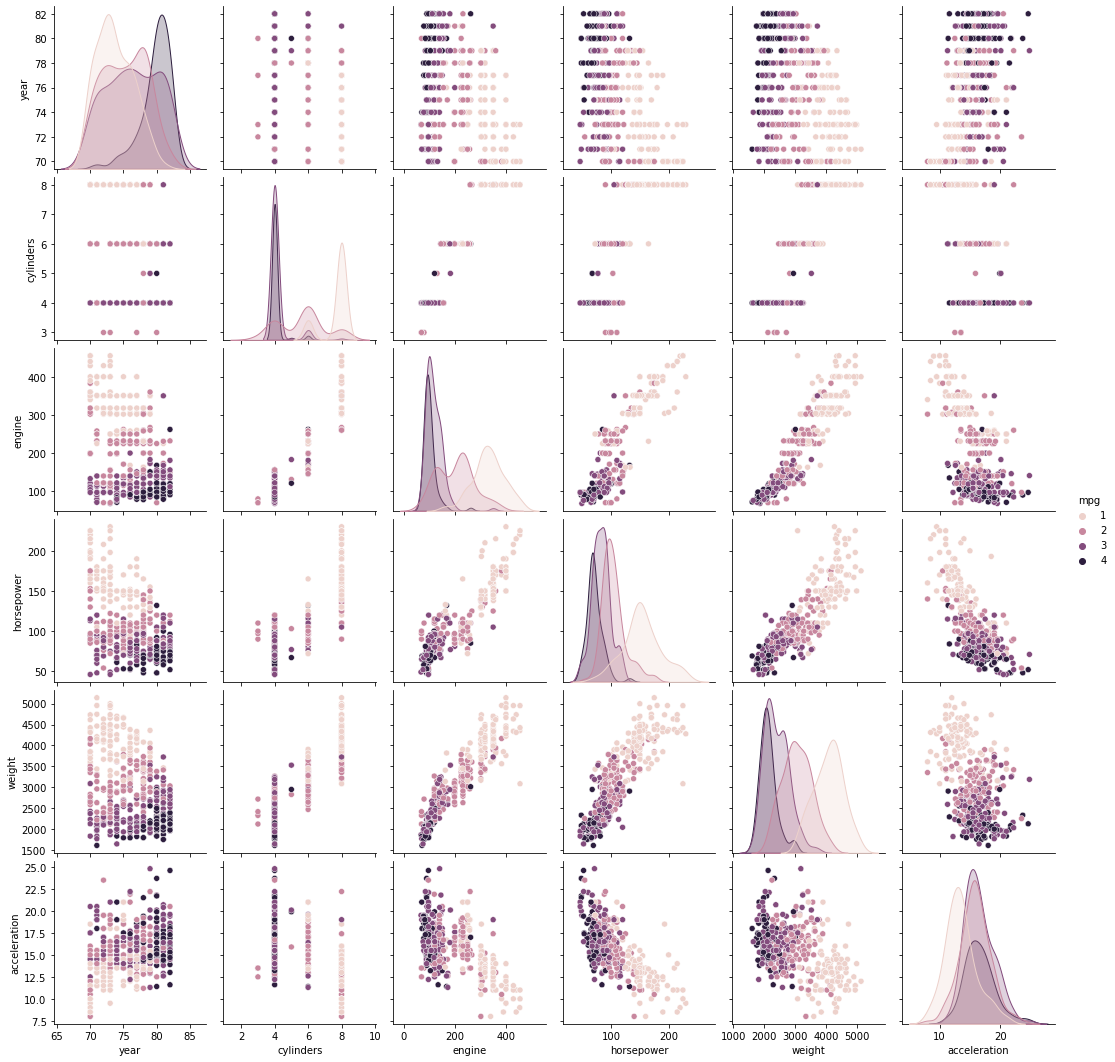

In [9]:
sns.pairplot(data, hue = 'mpg')

Ce graphique nous donne des informations sur la répartition de nos données. Il nous permet aussi de nous assurer que nos classes sont bien définis. 

Nos données semble avoir une distribution normale pour la pluspart, ce qui intéressant si nous prévoyons d'utiliser un modèle qui suppose que les données suivent une distribution normale.

De plus on remarque que les classes 1 et 2 se démarquent plus facilement des autres. Notre algorithme devrait avoir donc plus facilité à distinguer des individus appartenant à ces classes. Ce qui est moins le cas pour les classes 3 et 4. On remarque aussi le très faible nombre d'outliers, ce qui est aussi une bonne nouvelle pour la partie apprentissage supervisé. 

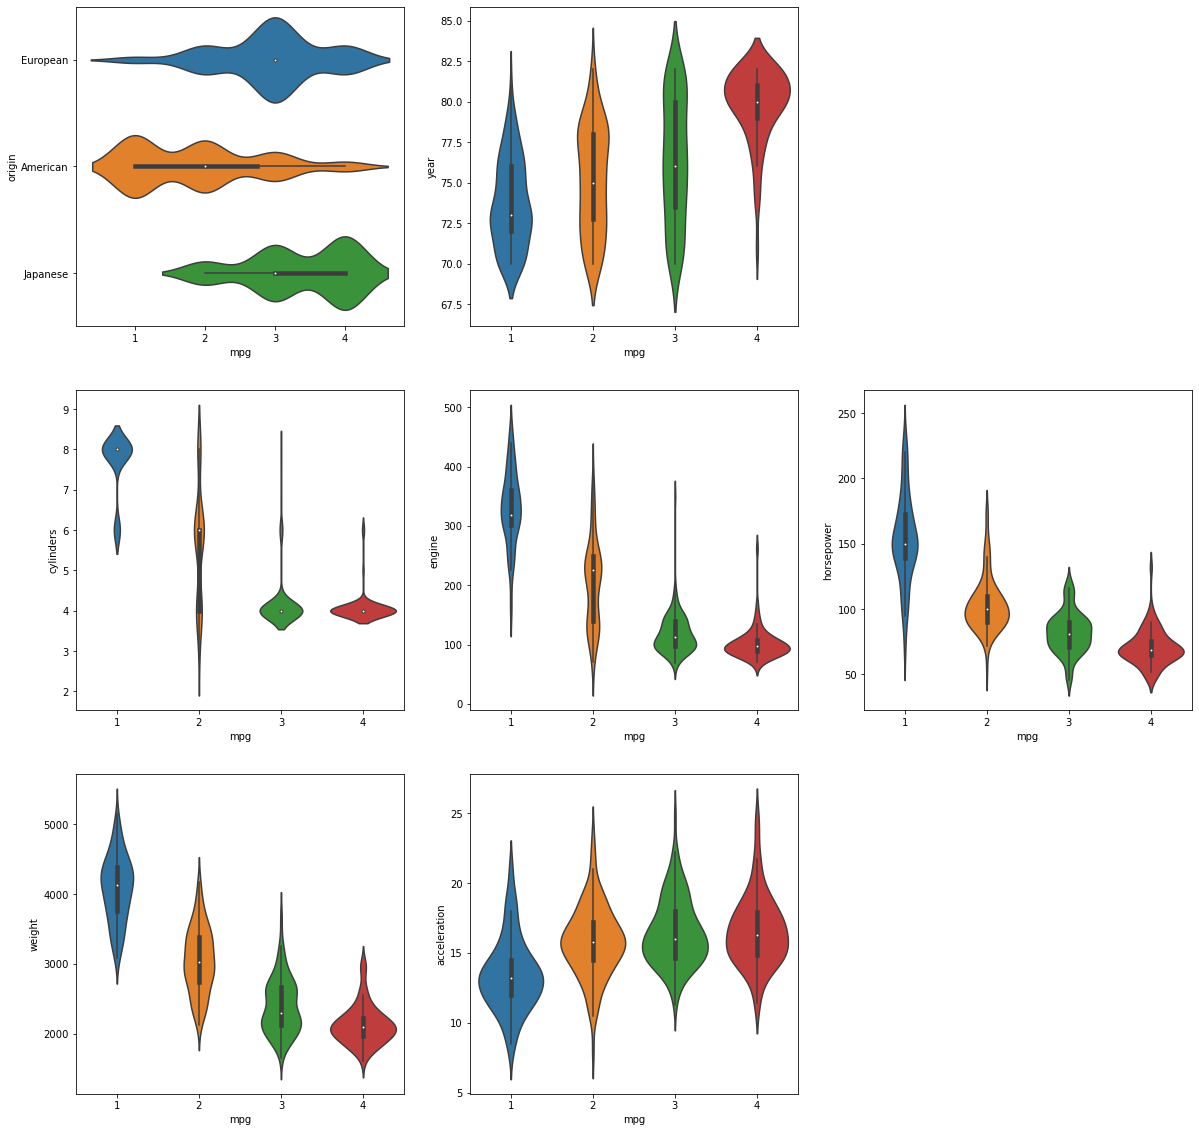

In [10]:
plt.figure(figsize = (20,20))

for index, col in enumerate(data.columns) : 
    if (col == "mpg") or (col == "name"):
        continue
    plt.subplot(3, 3, index)
    sns.violinplot(x = 'mpg', y = col, data = data) 

Nous pouvons également faire des violon plots des données pour comparer les distributions des classes. Les graphiques en violon contiennent les mêmes informations que les boxplots mais mettent également à l'échelle en fonction de la densité des données.

On remarque ici, que l'origine du véhicule semble donner beaucoup d'information sur l'appatenance à une classe. Ainsi la majorité des véhicules de la classe 4 semble être d'origine Japonaise, et ceux de la classe 1 semble être majoritairement d'origine Américaine.

Un autre point important est de regarder la répartition de nos classes, afin de voir si nous sommes dans un cas de classes déséquilibrées. 

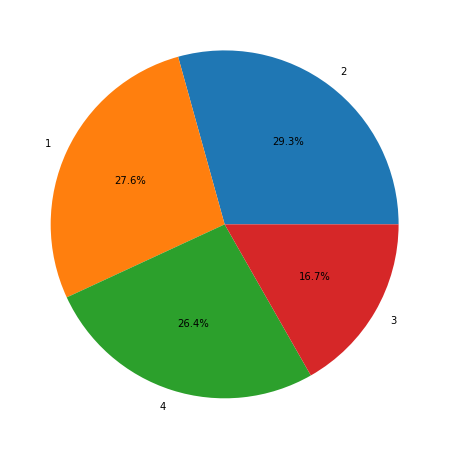

In [11]:
plt.figure(figsize = (12,8))
plt.pie(data['mpg'].value_counts(), labels = data['mpg'].unique(), autopct = '%1.1f%%')
plt.show()

La classe 3 est minoritaire, mais nous nous ne sommes pas dans un cas de fort déséquilibre entre les classes. A priori, le modèle ne sera que faiblement affecté par ce léger déséquilibre. 

Une dernière observation qui est intéressante à faire, est la matrice de corrélation. Elle nous donne des informations sur les corrélations entre les variables. 

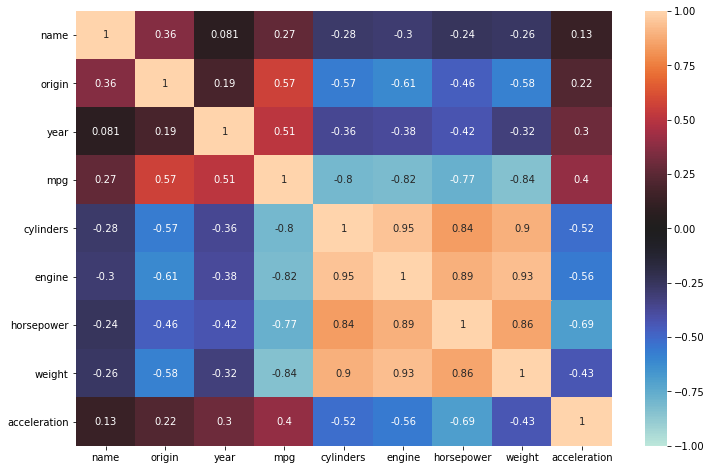

In [24]:
plt.figure(figsize = (12,8))
sns.heatmap(data.corr(), annot = True, vmax = 1, vmin = -1, center = 0)
plt.show()

On remarque que les variables cylinders, engine, horsepower et weight sont inversement corrélées à la variable mpg (notre variable target). Sachant qu'une corrélation négative entre deux variables indique que les valeurs d'une variable tendent à augmenter lorsque celles de l'autre variable diminuent. Et que pour la fonction de corrélation python, la variable mpg est de type int. On peut en déduire que lorsque les variables cylinders, engine, horsepower et weight augmentent, les véhicules sont plutôt de la classe 1 et 2 et inversement. 

Maintenant que nous avons récolté suffisament de données sur notre dataset, qu'il est nettoyé, nous allons pouvoir passer à l'étape suivante, qui est le choix d'un modèle.

## Etape n°3 - Choix et construction du modèle

Vous pouvez tester plusieurs modèles mais il faut dans tous les cas justifier en quoi cette architecture/modèle est pertinente par rapport à la problématique. 

In [1]:
#Importation des librairies nécessaires pour la création de modèle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

Nous avons choisis d'utiliser les arbres de classifications pour résoudre notre problème. L'avantage des arbre de classifications est qu'ils sont invariants à l'échelle, c'est-à-dire que l'échelle des fonctionnalités n'affecte pas leurs performances, contrairement à de nombreux modèles d'apprentissage automatique. En d'autres termes, peu importe si nos caractéristiques vont de 0 à 1 ou de 0 à 1 000, les classificateurs d'arbre de décision fonctionneront avec eux de la même manière.

Cependant il nous faut encoder nos variables de type object, car un arbre de décision ne prend en compte que des variables numériques.

In [22]:
#Drop de la colonne name qui n'est pas utile ici
data.drop('name', axis = 1, inplace = True)

#Encodage des variables de types object
def preprocessing(data) : 
    for col in data.select_dtypes("object").columns : 
        data = pd.get_dummies(data, columns = [col])
    return data

In [23]:
data = preprocessing(data)
data.head()

,year,mpg,cylinders,engine,horsepower,weight,acceleration,origin_American,origin_European,origin_Japanese
0,76,2,4,130.0,102.0,3150,15.7,0,1,0
1,76,1,8,304.0,120.0,3962,13.9,1,0,0
2,71,2,6,258.0,110.0,2962,13.5,1,0,0
3,73,2,6,232.0,100.0,2945,16.0,1,0,0
4,80,4,4,90.0,48.0,2335,23.7,0,1,0


Maintenant que nous avons encodé nos variables, nous pouvons définir les variables qui vont servir à l'apprentissage, et celle qui est notre variable target (mpg). De plus les algorithmes prennent en général des tableaux de données en entrée (de type numpy.array).

In [24]:
inputs = data[['year', 'cylinders','engine', 'horsepower', 'weight',
               'acceleration', 'origin_American', 'origin_European', 'origin_Japanese']].values

classes = data['mpg'].values

Ensuite nous allons séparer nos données en train et test set. La partie train qui contient la majorité de nos données va servir à entrainer nos données (comme son nom l'indique). La partie test nous sert à valider l'éfficacité de notre modèle.

In [25]:
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(inputs, classes, train_size = 0.75, random_state = 10)


Maintenant que nous avons définis nos matrices, nous allons pouvoir utiliser un premier modèle, un DecisionTreeClassifier, le modèle le plus simple basé sur le fonction des arbres. Nous n'allons pas paramètrer ce modèle afin de voir ses performances de base (sachant qu'en paramétrant l'arbre de décision, nous allons augmenter ses performances).

In [26]:
DecisionTree = DecisionTreeClassifier()
DecisionTree.fit(X_train, y_train)
DecisionTree.score(X_test, y_test)

0.7156862745098039

On obtient un résultat convenable, mais laissant une marge de progression pour améliorer notre modèle. De plus ce résultat peut être sensible à la partition des données sélectionnées pour le train set. En effet, selon les données sélectionnées pour le train set, la performance de notre modèle peut varier. Nous allons donc faire une simple vérification en répetant 100 fois l'opération (sachant qu'un simple arbre de décision sur un dataset de cette taille ne prend que peut de temps à ce construire, notre code ne devrait pas tourner trop longtemps pour 100 itérations).

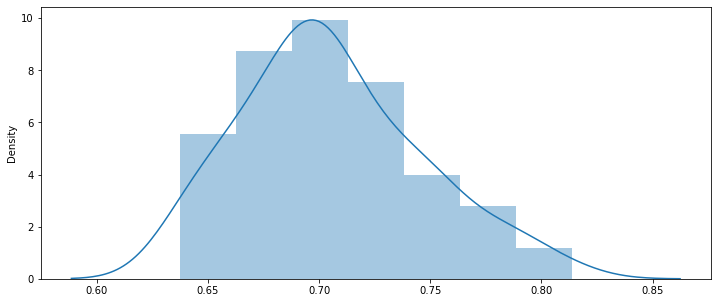

In [27]:
model_accuracies = []

for repetition in range(100):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(inputs, classes, train_size=0.75)
    
    DecisionTree = DecisionTreeClassifier()
    DecisionTree.fit(training_inputs, training_classes)
    classifier_accuracy = DecisionTree.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)

plt.figure(figsize = (12,5))   
sns.distplot(model_accuracies)
plt.show()

Nos craintes sont confirmées, les performances de notre modèle varient grandement en fonction du train set. Une méthode pour résoudre ce problème est la cross-validation. 

La cross-validation divise l'ensemble de données d'origine en k sous-ensembles, utilise l'un des sous-ensembles comme ensemble de test, et le reste des sous-ensembles est utilisés comme ensemble d'apprentissage. Ce processus est ensuite répété k fois de sorte que chaque sous-ensemble soient utilisés comme ensemble de test exactement une fois.

La validation croisée avec k = 10, est le choix le plus courant, nous allons alors utiliser cette valeur. 

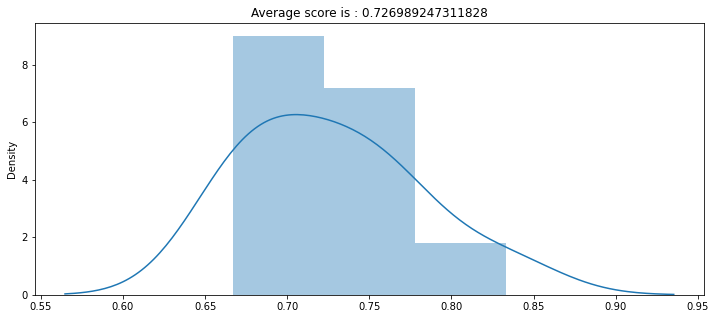

In [28]:
cv_scores = cross_val_score(DecisionTree, training_inputs, training_classes, cv = 10)

plt.figure(figsize = (12,5))
sns.distplot(cv_scores)
plt.title(f"Average score is : {np.mean(cv_scores)}")
plt.show()

Nous avons maintenant une évaluation bien plus précise de la précision de notre modèle.

Nous allons maintenant améliorer notre modèle en modifiant les hyper-paramètre de celui-ci. 

Cependant nous allons aussi tester un autre algorithme qui pourrait nous donner de meilleurs résultats qu'un simple arbre de décision. L'algorithme du RandomForest. Une forêt aléatoire est un méta estimateur qui adapte un certain nombre de classificateurs d'arbre de décision sur divers sous-échantillons de l'ensemble de données et utilise la moyenne pour améliorer la précision prédictive et contrôler l'over-fitting.

## Etape n°4 - Evaluation et validation

Optimisez votre(vos) modèle(s) et donnez des résultats chiffrés/visuels de la pertinence de votre solution. Commentez les résultats. 

On utilise une fonction de sklearn qui permet de tester un ensemble de valeurs par hyper-paramètre et ainsi chercher la meilleure combinaison afin de maximiser les performances du modéle.

In [32]:
params = {'criterion' : ['gini', 'entropy'],
          'splitter' : ['best', 'random'],
          'max_features' : [4, 6, 8, 10],
          'max_depth' : [8, 10, 12, None]
         }

grid_search = GridSearchCV(DecisionTree, param_grid = params, cv = 10)
grid_search.fit(training_inputs, training_classes)

print(f"Best score : {grid_search.best_score_}")
print(f"Best parameters : {grid_search.best_params_}")
print(f"Best estimator : {grid_search.best_estimator_}")

DecisionTree = grid_search.best_estimator_

Best score : 0.7405376344086022
Best parameters : {'criterion': 'gini', 'max_depth': 12, 'max_features': 8, 'splitter': 'best'}
Best estimator : DecisionTreeClassifier(max_depth=12, max_features=8)


Enfin on définit notre arbre de décision avec les meilleurs hyper-paramètres. 

On réalise cette même opérations pour le RandomForest.

In [36]:
RandonForest = RandomForestClassifier()

params = {'n_estimators' : [100, 150, 200],
          'criterion' : ['gini', 'entropy'],
          'max_features' : [2, 4, 6, 8],
          'max_depth' : [10, 12, 15, None],
          'warm_start' : [True, False]
         }

grid_search = GridSearchCV(RandonForest, param_grid = params, cv = 10)
grid_search.fit(training_inputs, training_classes)

print(f'Best score : {grid_search.best_score_}')
print(f'Best parameters : {grid_search.best_params_}')
print(f'Best estimator : {grid_search.best_estimator_}')

RandonForest = grid_search.best_estimator_

Best score : 0.7663440860215054
Best parameters : {'criterion': 'entropy', 'max_depth': 15, 'max_features': 6, 'n_estimators': 100, 'warm_start': False}
Best estimator : RandomForestClassifier(criterion='entropy', max_depth=15, max_features=6)


On obtient de meileur résultats avec le RandomForest ! Cela s'explique par la construction de l'agorithme de RandomForest, en effet un ensemble d'apprentissage même constitué de plusieurs arbre avec des performances faibles, aura de bonne performance lorsque les arbres sont assemblés les uns aux autres. L'ensemble représente donc un modèle fort.

On va maintenant comparer les deux algorithmes afin de s'assurer que le RandomForest est bien celui qui nous donnera les meilleurs performances. 

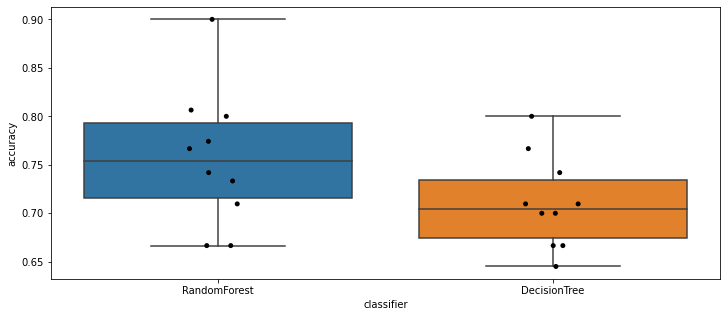

In [34]:
rf_data = pd.DataFrame({'accuracy' : cross_val_score(RandonForest, training_inputs, training_classes, cv = 10),
                        'classifier' : ['RandomForest'] * 10})
dt_data = pd.DataFrame({'accuracy' : cross_val_score(DecisionTree, training_inputs, training_classes, cv = 10),
                        'classifier' : ['DecisionTree'] * 10})

tot_data = rf_data.append(dt_data)

plt.figure(figsize = (12,5))
sns.boxplot(x = 'classifier', y = 'accuracy', data = tot_data)
sns.stripplot(x = 'classifier', y = 'accuracy', data = tot_data, jitter = True, color = 'black')
plt.show()

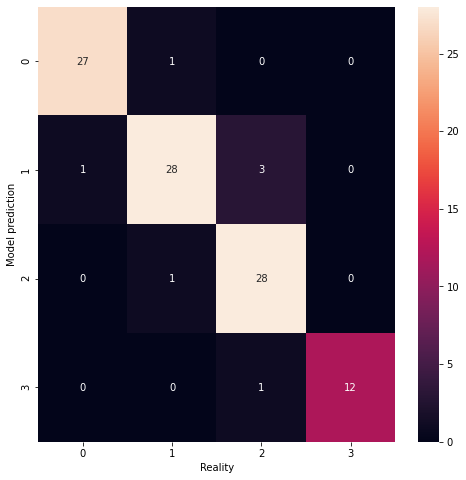

In [35]:
y_pred = RandonForest.predict(X_test)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt = 'g')
plt.xlabel("Reality")
plt.ylabel("Model prediction")
plt.show()

### Conclusion

Sur ce graphique nous voyons bien que l'algorithme RandomForest est plus performant. Les performances sont probablement limités à cause de notre dataset. En effet pour avoir de meilleurs performances, un plus grand nombres de données peut être une solution. 

On peut donc conclure sur ce projet, nous avons vu le processus de traitement des données afin de les préparer à être analysées graphiquement. Enfin nous avons vu l'implementation et l'amélioration de modèles de machine learning comme les arbres de décision ou les forêts aléatoires. 

Avec un RandomForest nous avons pu obtenir un scoring moyen de 76%. Nous nous sommes volontairement pas tournés vers des algortihmes utilisant des méthodes de boosting comme le BaggingClassifier, AdaboostClassifier ou encore XGBoostClassifier car les données dont nous disposons ne nécéssitent pas de se lancer dans des algorithmes plus complexe comme ceux là. Sachant qu'ils sont aussi plus dificiles à paramétrer. 

Les résultats sont bon avec un RandomForest, et des données assez simple comme les nôtres ne nécessite pas plus complexe comme algorithme (les résultats risqueraient d'être les mêmes avec XGBoost, Adaboost, etc.).